## FIR FILTER SIMULATION

In the following code it is implemented a python simulation of the whole circuit, which components are: sampler generator, uart receiver, fir filter, baudrate generator and uart transmitter. The goal is to represent in the closest possibile way how the circuit synthesized in the FPGA actually works.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

##CLOCK##
max_t=32000
time=np.linspace(0,max_t,10*max_t)
clk=time.copy()
clk[clk%10<5]=0
clk[clk%10>=5]=1
clk_period=10

##CONSTANTS##
baud_rate=20 #the rate is taken much smaller than the actual one to reduce the computational weight of the program
bit_out=15 #number of bits of the fir filter output
coefficienti=[1,-4,7,-4,1] #coefficients used in the fir filter computation

##INPUT##
def bin8_conv(x):
    bin_list=np.zeros(10)
    bin_list[0]=1
    bin_list[9]=0
    i=1
    if x>=0:
        q=x
    elif x<0:
        q=256+x
    while q!=0:
        bin_list[i]=(q%2)
        q=int(q/2)
        i+=1
    return np.flip(bin_list)
    

input_dat=[21,4,-10,-24,5,19,-8]
x=time.copy()
start=[(a*4000)+500 for a in range(len(input_dat))]
x[x<start[0]]=1
for a in range(len(input_dat)):
    for i in range(10):
        x[np.all((x>=start[a]+(i*baud_rate*clk_period), x<start[a]+((i+1)*baud_rate*clk_period)),axis=0)]=bin8_conv(input_dat[a])[i]

    #x[np.all((x>=start+(16*baud_rate*clk_period), x<start+((16+1)*baud_rate*clk_period)),axis=0)]=0
x[x>1]=1

def rising_edge(clk,i):
    if clk[i-1]==0 and clk[i]==1:
        return True
    else:
        return False

def falling_edge(clk,i):
    if clk[i-1]==1 and clk[i]==0:
        return True
    else:
        return False

def baudrate_generator(clk,rate):
    br_list=[]
    count=0
    for i in range(len(clk)):
        if rising_edge(clk,i):
            count+=1
        if count==rate:
            br_list.append(clk[i])
        elif count==rate+1:
            count=1
            br_list.append(0)
        else:
            br_list.append(0)
        #print(count, br_list[i], count%rate, time[i])
    return br_list
            
def sampler_generator(x, clk, rate):
    samp_list=[]
    valid=[]
    count=0
    p_count=0
    activate=False
    for i in range(len(clk)):
        if falling_edge(x,i):
            activate=True
        if activate:
            valid.append(1)
            if p_count<10:
                if rising_edge(clk,i):
                    count+=1
                    if count==rate:
                        p_count+=1
                if count==int(rate/2):
                    samp_list.append(clk[i])
                elif count==rate+1:
                    count=1
                    samp_list.append(0)
                else:
                    samp_list.append(0)
            elif p_count==10:
                p_count=0
                activate=False
                samp_list.append(0)
            else:
                samp_list.append(0)
        else:
            samp_list.append(0)
            valid.append(0)
    return [samp_list, valid]
    
def uart_reciver(x, sg_clk, valid):
    sig=[0,0,0,0,0,0,0,0]
    sig1=sig.copy()
    data_valid=[]
    ur_list=np.ndarray((len(clk),8))
    count=0
    for i in range(len(clk)):
        data_valid.append(0)
        if valid[i]==1:
            if rising_edge(sg_clk,i):
                count+=1
                sampl_dat=x[i]
            if count==10:
                count=0
                sig1=sig.copy()
                data_valid[i]=1
            elif count>=2:
                sig[count-2]=sampl_dat
            
        ur_list[i]=sig1
    return [ur_list,data_valid]

def uart_transmitter(data, br_clk, data_valid):
    count=0
    ut_list=[]
    ok=False
    for i in range(len(clk)):
        if rising_edge(data_valid,i):
            ok=True
            my_dat=data[i].copy()
        if ok:
            if rising_edge(br_clk,i):
                count+=1
            if count==1:
                ut_list.append(0)
            elif count==10:
                ut_list.append(1)
                count=0
                ok=False
            else:
                ut_list.append(my_dat[count-2])
        else:
            ut_list.append(1)
    return ut_list

def decimal_conv(x):
    dec=0
    for i in range(len(x)-1):
        dec=dec+np.flip(x)[i]*(2**i)
    if x[0]==1:
        return dec-2**7
    elif x[0]==0:
        return dec


def binary_con(x):
    bin_list=np.zeros(bit_out)
    i=0
    if x>=0:
        q=x
        while q!=0:
            bin_list[i]=(q%2)
            q=int(q/2)
            i+=1
    elif x<0:
        q=((256)+x)
        while q!=0:
            bin_list[i]=(q%2)
            q=int(q/2)
            i+=1
        bin_list[i:bit_out]=1
    return np.flip(bin_list)

def fir_filter(data, data_valid):
    const=coefficienti
    result_list=[]
    xi=[0,0,0,0,0]
    add=[0,0,0,0,0]
    fir_list=np.ndarray((len(clk),8))
    result=0
    bin_res=[]
    for i in range(len(clk)):
        if rising_edge(data_valid,i):
            xi[4]=xi[3]
            xi[3]=xi[2]
            xi[2]=xi[1]
            xi[1]=xi[0]
            xi[0]=int(decimal_conv(data[i]))
            result=sum([a*b for a,b in zip(xi, const)])
            result_list.append(result)
            bin_res.append((binary_con(result))[3:11])
        fir_list[i]=(binary_con(result))[3:11]
    return [fir_list, result_list, np.array(bin_res)]

#sample generator
my_sg=sampler_generator(x, clk, baud_rate)[0]
my_vld=sampler_generator(x, clk, baud_rate)[1]
#uart reciver
my_ur=uart_reciver(x, my_sg, my_vld)[0]
my_dv=uart_reciver(x, my_sg, my_vld)[1]
#fir filter
my_fir=fir_filter(my_ur, my_dv)[0]
my_res=fir_filter(my_ur, my_dv)[1]
my_bre=fir_filter(my_ur, my_dv)[2]
#baudrate generator
my_br=baudrate_generator(clk, baud_rate)
#uart transmitter
my_ut=uart_transmitter(my_fir, my_br, my_dv)

fig, (f_x, f_sg, f_br, f_dv, f_ut)=plt.subplots(nrows=5, ncols=1, figsize=(16,2.5))
f_x.plot(time, x, label='IN')
f_x.set_yticks([])
f_x.set_xticks([])
f_x.set_xbound(0, max_t)
f_x.legend(loc='upper right')
f_sg.plot(time, my_sg, label='SAMP GEN')
f_sg.set_yticks([])
f_sg.set_xticks([])
f_sg.set_xbound(0, max_t)
f_sg.legend(loc='upper right')
f_br.plot(time, my_br, label='BAUDRATE')
f_br.set_yticks([])
f_br.set_xticks([])
f_br.set_xbound(0, max_t)
f_br.legend(loc='upper right')
f_dv.plot(time, my_dv, label='DATA VAL')
f_dv.set_yticks([])
f_dv.set_xticks([])
f_dv.set_xbound(0, max_t)
f_dv.legend(loc='upper right')
f_ut.plot(time, my_ut, label='OUT')
f_ut.set_yticks([])
f_ut.set_xbound(0, max_t)
f_ut.set_xlabel('time')
f_ut.legend(loc='upper right')
plt.show()

<Figure size 1600x250 with 5 Axes>

Results summary

In [2]:
def my_conv(x):
    dec=0
    for i in range(len(x)-1):
        dec=dec+np.flip(x)[i]*(2**(i+4))
    if dec<2**10:
        return dec
    elif dec>=2**10:
        return dec-(2**11)
    
print('INPUT\n')

print('binario')
for n in input_dat:
    print(bin8_conv(n))
print('\ndecimale')
print(input_dat)


print('\nOUPUT\n')
print('binario')
print(my_bre, '\n')
print('output filtro')
print('  risultato esatto')
print(my_res,'\n')
print('  risultato approssimato')
app_r=[]
for i in range(len(my_bre)):
    app_r.append(my_conv(my_bre[i]))
print(app_r)

print('\nconversione coefficienti')
print('  risultato esatto')
print((np.array(my_res)/32).tolist(),'\n')
print('  risultato approssimato')
print((np.array(app_r)/32).tolist())

INPUT

binario
[0. 0. 0. 0. 1. 0. 1. 0. 1. 1.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
[0. 1. 1. 1. 1. 0. 1. 1. 0. 1.]
[0. 1. 1. 1. 0. 1. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 1. 0. 1. 1.]
[0. 0. 0. 0. 1. 0. 0. 1. 1. 1.]
[0. 1. 1. 1. 1. 1. 0. 0. 0. 1.]

decimale
[21, 4, -10, -24, 5, 19, -8]

OUPUT

binario
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]] 

output filtro
  risultato esatto
[21, -80, 121, -40, 36, -125, 37] 

  risultato approssimato
[16.0, -80.0, 112.0, -48.0, 32.0, -128.0, 32.0]

conversione coefficienti
  risultato esatto
[0.65625, -2.5, 3.78125, -1.25, 1.125, -3.90625, 1.15625] 

  risultato approssimato
[0.5, -2.5, 3.5, -1.5, 1.0, -4.0, 1.0]


## NUMERIC SIMULATION OF FIR FILTER

In the following code it is implemented a simulation which focuses only on the numerical results of the process, so the complexity the code decreases and it is possibile to analise a larger number of datas.

INPUT DATASET

[0, 7, -2, 2, -7, 16, -6, 11, -12, 22, -6, 16, -12, 23, -3, 17, -8, 19, 4, 13, -1, 11, 13, 7, 8, 2, 22, 1, 16, -4, 27, -1, 20, -8, 28, 0, 20, -7, 23, 3, 16, -2, 14, 10, 8, 4, 3, 17, 0, 10, -6, 22, -5, 14, -13, 22, -7, 14, -15, 17, -6, 9, -13, 8, 0, 1, -7, -3, 5, -7, -1, -14, 10, -14, 3, -22, 12, -18, 4, -25, 9, -16, 1, -23, 2, -11, -4, -17, -7, -4, -11, -10, -17, 3, -18, -2, -25, 8, -21, 1, -28, 8, -19, 1, -25, 4, -13, -1, -18, -2, -4, -6, -9, -10, 5, -11, 0, -17, 13, -14, 7, -20, 16, -12, 10, -18, 15, -6, 9, -11, 9, 3, 5, -1, 1, 13, 0, 8, -5, 21, -3, 16, -9, 26, -3, 19, -9, 25, 0, 18, -5, 19, 7, 13, 2, 10, 16, 7, 10, 1, 23, 0, 17, -6, 27, -2, 20, -9, 26, -1, 18, -8, 19, 2, 12, -3, 9, 9, 4, 2, -1, 15, -4, 8, -11, 19, -9, 11, -18, 18, -11, 10, -19, 12, -8, 4, -15, 2, -3, -3] 

PYTHON OUTPUT DATASET

[0.0, 0.0, -1.0, 1.5, -2.0, 2.0, -4.5, 5.5, -5.5, 5.5, -7.5, 7.5, -7.0, 7.0, -8.0, 7.5, -6.5, 6.0, -6.5, 5.5, -3.5, 3.0, -3.0, 1.5, 0.5, -1.0, 1.5, -3.5, 5.0, -5.0, 5.0, -6.5,

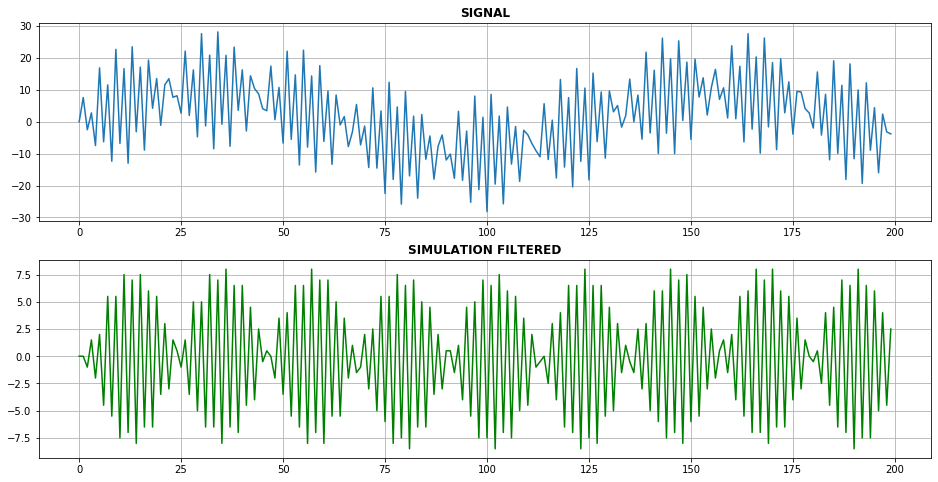

In [12]:
import random
import numpy as np

time=np.arange(0, 20, 0.1)
news=np.sin(time*30)*15+np.sin(time/2)*10+np.sin(time*15)*5
#news=[21,4,-10,-24,5,19,-8]
time=np.arange(len(news))

print('INPUT DATASET\n')
print(np.array(news).astype(int).tolist(), '\n')
print('PYTHON OUTPUT DATASET\n')
co=[1,-4,7,-4,1]
xo=[0,0,0,0,0]
res=[]
for i in range(len(news)):
    xo[4]=xo[3]
    xo[3]=xo[2]
    xo[2]=xo[1]
    xo[1]=xo[0]
    xo[0]=np.array(news).astype(int).tolist()[i]
    res.append(int(np.floor(np.array(sum([a*b for a,b in zip(xo, co)])/16)))/2)
print(np.array(res).tolist(),'\n')

fg, ((orig, simu))= plt.subplots(nrows=2, ncols=1, figsize=(16,8))

orig.plot(time, news)
orig.set_title('SIGNAL', fontweight='bold')
orig.grid(True)
simu.plot(time, np.array(res).round(4).tolist(), 'g')
simu.set_title('SIMULATION FILTERED', fontweight='bold')
simu.grid(True)
plt.show()
